In [59]:
import sys
sys.path.append('../')

import albumentations as A
import src.training as train
import src.dataset as dataset
from  src.models import resnet,siamesenet
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
import torch.nn.functional as F

In [86]:
import os
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def test_dir(model, device, img_ref_path, dir, input_size = (105,105)):
    positives = os.listdir(os.path.join(dir,'positives'))
    negatives = os.listdir(os.path.join(dir,'negatives'))
    model.to(device).eval()
    img_ref = Image.open(img_ref_path).resize(input_size).convert("RGB")
    img_ref = transforms.functional.to_tensor(img_ref).unsqueeze(0).to(device)
    positive_predictions = []
    for positive in positives:
        img = Image.open(os.path.join(dir,'positives',positive)).resize(input_size).convert("RGB")
        img = transforms.functional.to_tensor(img).unsqueeze(0).to(device)
        pred = (F.sigmoid(model(img_ref,img)) > 0.5).float().item()
        positive_predictions.append(pred)
    negative_predictions = []
    for negative in negatives:
        img = Image.open(os.path.join(dir,'negatives',negative)).resize(input_size).convert("RGB")
        img = transforms.functional.to_tensor(img).unsqueeze(0).to(device)
        pred = (F.sigmoid(model(img_ref,img)) > 0.5).float().item()
        negative_predictions.append(pred)
    all_labels = [1.0 for label in range(len(positives))] + [0.0 for label in range(len(negatives))]
    all_predictions = positive_predictions + negative_predictions
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=1)
    recall = recall_score(all_labels, all_predictions, zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    return accuracy,precision,recall,conf_matrix


In [165]:
batch_size = 256

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop((248, 248)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=1.0),
    A.GridElasticDeform(num_grid_xy = (10,10), magnitude = 15, p=1.0),
    A.Resize(248,248),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

In [147]:
img1,img2,label = next(iter(dataloader['train']))

Class: 0.0


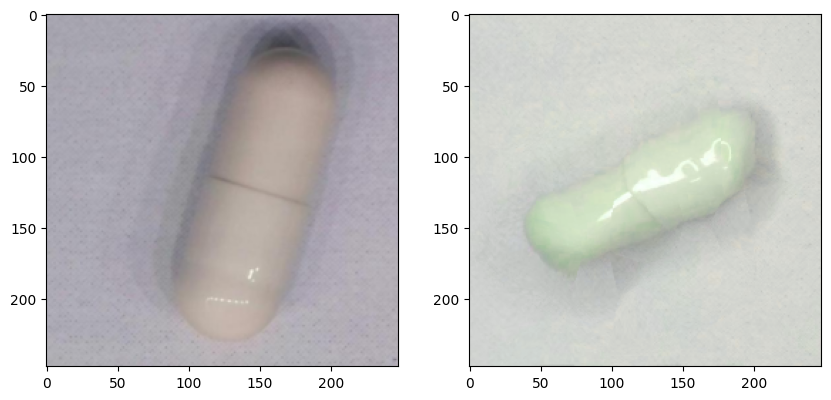

In [162]:
index = 90
print("Class:",label[index].item())
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img1[index].permute(1, 2, 0))
ax[1].imshow(img2[index].permute(1, 2, 0))

# Training

## Augumented Resnet

In [167]:
backbone = resnet.prunnedResnet18(
    pretrained=True,
    freeze_ratio=0.8,
    remove_classifier=True,
    reinit_weigths=False)
model = siamesenet.siameseNet(backbone,512)
result = train.train_siamese_network_V2(model=model,
                                        dataloader=dataloader,
                                        name="siamese_resnet_18",
                                        checkpoint_path="..//checkpoints",
                                        epochs=10)

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,6

val_loss 0.27822 val_acc 0.91939: 100%|██████████| 36/36 [06:37<00:00, 11.05s/it]


Epoch 1/10 loss 0.48555 val_loss 0.27822 acc 0.73353 val_acc 0.91939
Best model saved with Validation Accuracy: 0.9194


val_loss 0.17576 val_acc 0.96089: 100%|██████████| 36/36 [05:52<00:00,  9.78s/it]


Epoch 2/10 loss 0.27183 val_loss 0.17576 acc 0.90109 val_acc 0.96089
Best model saved with Validation Accuracy: 0.9609


val_loss 0.13216 val_acc 0.97388: 100%|██████████| 36/36 [06:07<00:00, 10.21s/it]


Epoch 3/10 loss 0.19874 val_loss 0.13216 acc 0.93756 val_acc 0.97388
Best model saved with Validation Accuracy: 0.9739


val_loss 0.11329 val_acc 0.98054: 100%|██████████| 36/36 [06:09<00:00, 10.27s/it]


Epoch 4/10 loss 0.16489 val_loss 0.11329 acc 0.95043 val_acc 0.98054
Best model saved with Validation Accuracy: 0.9805


val_loss 0.09384 val_acc 0.98100: 100%|██████████| 36/36 [06:09<00:00, 10.27s/it]


Epoch 5/10 loss 0.14529 val_loss 0.09384 acc 0.96085 val_acc 0.98100
Best model saved with Validation Accuracy: 0.9810


val_loss 0.08829 val_acc 0.98170: 100%|██████████| 36/36 [06:10<00:00, 10.28s/it]


Epoch 6/10 loss 0.12702 val_loss 0.08829 acc 0.96595 val_acc 0.98170
Best model saved with Validation Accuracy: 0.9817


val_loss 0.08136 val_acc 0.98463: 100%|██████████| 36/36 [06:16<00:00, 10.45s/it]


Epoch 7/10 loss 0.12038 val_loss 0.08136 acc 0.96371 val_acc 0.98463
Best model saved with Validation Accuracy: 0.9846


val_loss 0.07713 val_acc 0.98444: 100%|██████████| 36/36 [06:20<00:00, 10.57s/it]


Epoch 8/10 loss 0.10364 val_loss 0.07713 acc 0.97508 val_acc 0.98444


val_loss 0.06776 val_acc 0.98708: 100%|██████████| 36/36 [07:53<00:00, 13.16s/it]


Epoch 9/10 loss 0.09964 val_loss 0.06776 acc 0.97478 val_acc 0.98708
Best model saved with Validation Accuracy: 0.9871


val_loss 0.07043 val_acc 0.98886: 100%|██████████| 36/36 [09:32<00:00, 15.92s/it]


Epoch 10/10 loss 0.09509 val_loss 0.07043 acc 0.97555 val_acc 0.98886
Best model saved with Validation Accuracy: 0.9889


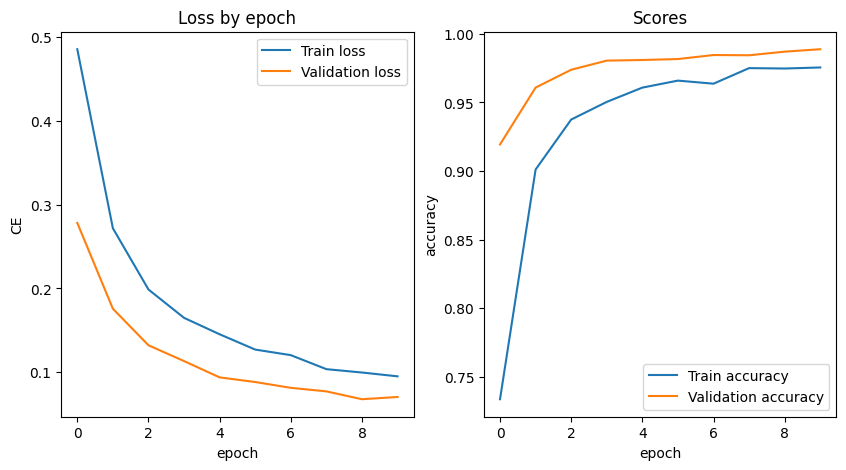

In [172]:
train.show_graph(result)

In [168]:
backbone = resnet.prunnedResnet18(
    pretrained=True,
    freeze_ratio=0.65,
    remove_classifier=True,
    reinit_weigths=False)
model = siamesenet.siameseNet(backbone,512)
checkpoint = torch.load('../checkpoints/Siamese_resnet_18.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640


<All keys matched successfully>

Test Accuracy: 0.9649
Test Precision: 0.9028
Test Recall: 0.9375


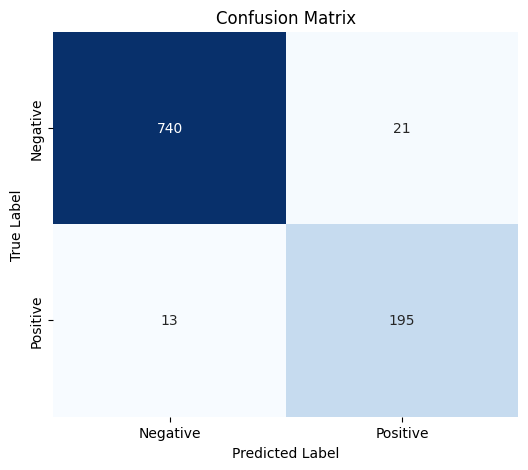

(0.9649122807017544,
 0.9027777777777778,
 0.9375,
 array([[740,  21],
        [ 13, 195]], dtype=int64))

In [169]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

train.evaluate_model(test_loader=test_dataloader,
                     model=model)

Test Accuracy: 0.8879
Test Precision: 0.8045
Test Recall: 0.9125


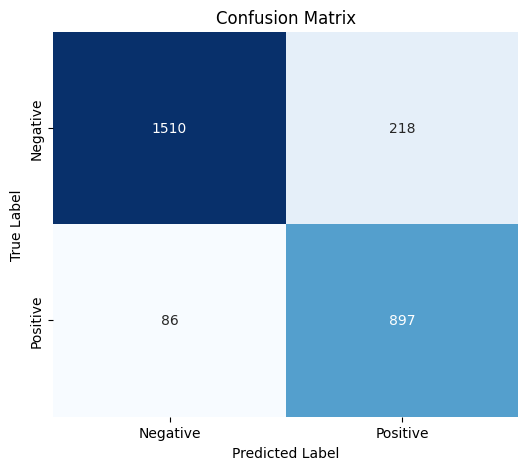

(0.8878642567318332,
 0.8044843049327354,
 0.9125127161749745,
 array([[1510,  218],
        [  86,  897]], dtype=int64))

In [170]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_not_used_classes",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)

Test Accuracy: 0.4286
Test Precision: 0.5385
Test Recall: 0.5385


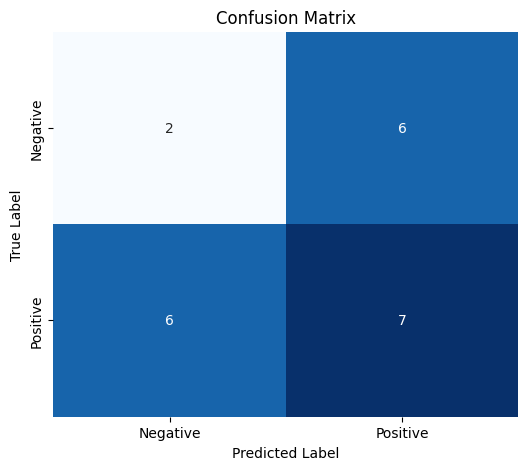

(0.42857142857142855,
 0.5384615384615384,
 0.5384615384615384,
 array([[2, 6],
        [6, 7]], dtype=int64))

In [171]:
test_dir(model=model,
         device=device,
         img_ref_path ='..\\data\\rl_scenario_test\\positives\pill_2.png',
         dir ='..\\data\\rl_scenario_test\\',
         input_size=(248,248),
)

## OG Paper

In [17]:
batch_size = 256

transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=1.0),
    A.GridElasticDeform(num_grid_xy = (10,10), magnitude = 15, p=1.0),
    A.Resize(105,105),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

In [7]:
backbone = siamesenet.OneShot()
model = siamesenet.siameseNet(backbone)
result = train.train_siamese_network_V2(model=model,
                                        dataloader=dataloader,
                                        epochs=10,
                                        name="siamese_og",
                                        checkpoint_path="..//checkpoints")

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

val_loss 0.37980 val_acc 0.83039: 100%|██████████| 36/36 [05:58<00:00,  9.96s/it]


Epoch 1/10 loss 0.44049 val_loss 0.37980 acc 0.76130 val_acc 0.83039
Best model saved with Validation Accuracy: 0.8304


val_loss 0.29933 val_acc 0.88727: 100%|██████████| 36/36 [06:06<00:00, 10.19s/it]


Epoch 2/10 loss 0.30483 val_loss 0.29933 acc 0.87648 val_acc 0.88727
Best model saved with Validation Accuracy: 0.8873


val_loss 0.26282 val_acc 0.90264: 100%|██████████| 36/36 [06:13<00:00, 10.37s/it]


Epoch 3/10 loss 0.27594 val_loss 0.26282 acc 0.89416 val_acc 0.90264
Best model saved with Validation Accuracy: 0.9026


val_loss 0.28464 val_acc 0.87406: 100%|██████████| 36/36 [06:07<00:00, 10.20s/it]


Epoch 4/10 loss 0.24516 val_loss 0.28464 acc 0.91328 val_acc 0.87406


val_loss 0.43830 val_acc 0.79968: 100%|██████████| 36/36 [06:06<00:00, 10.18s/it]


Epoch 5/10 loss 0.24632 val_loss 0.43830 acc 0.90829 val_acc 0.79968


val_loss 0.36383 val_acc 0.81689: 100%|██████████| 36/36 [06:07<00:00, 10.21s/it]


Epoch 6/10 loss 0.21724 val_loss 0.36383 acc 0.92173 val_acc 0.81689


val_loss 0.42837 val_acc 0.76215: 100%|██████████| 36/36 [06:09<00:00, 10.26s/it]


Epoch 7/10 loss 0.20789 val_loss 0.42837 acc 0.92572 val_acc 0.76215


val_loss 0.46321 val_acc 0.74644: 100%|██████████| 36/36 [06:09<00:00, 10.26s/it]


Epoch 8/10 loss 0.20783 val_loss 0.46321 acc 0.92395 val_acc 0.74644


val_loss 0.48067 val_acc 0.71479: 100%|██████████| 36/36 [06:08<00:00, 10.25s/it]


Epoch 9/10 loss 0.21022 val_loss 0.48067 acc 0.92127 val_acc 0.71479


val_loss 0.50157 val_acc 0.76703: 100%|██████████| 36/36 [06:09<00:00, 10.28s/it]

Epoch 10/10 loss 0.19288 val_loss 0.50157 acc 0.92924 val_acc 0.76703


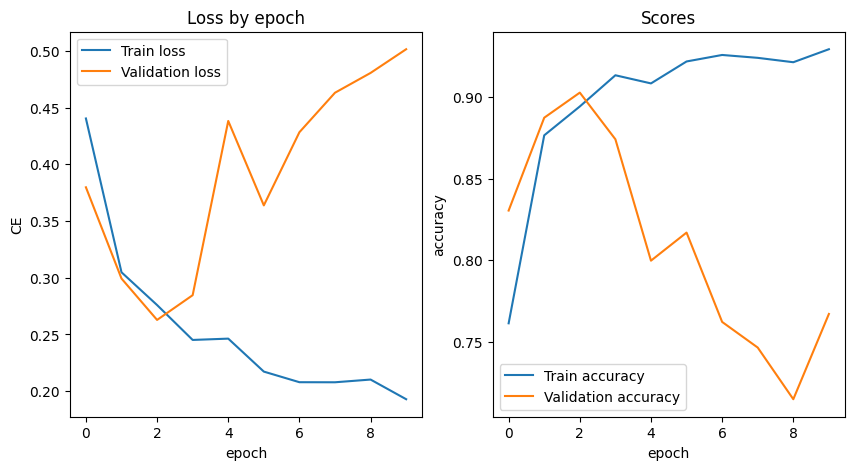

In [8]:
train.show_graph(results=result)

In [16]:
backbone = siamesenet.OneShot()
model = siamesenet.siameseNet(backbone)
checkpoint = torch.load('../checkpoints/siamese_og.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

<All keys matched successfully>

Test Accuracy: 0.9329
Test Precision: 0.8389
Test Recall: 0.8510


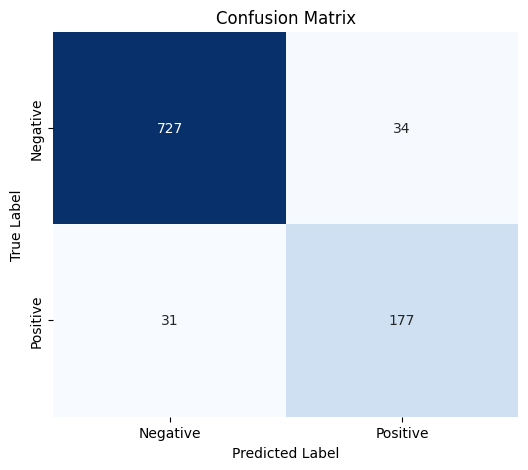

(0.932920536635707,
 0.8388625592417062,
 0.8509615384615384,
 array([[727,  34],
        [ 31, 177]], dtype=int64))

In [18]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)

## Non-augmented resnet

In [163]:
batch_size = 256

transform = transforms.Compose([
    transforms.Resize((248, 248)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=1.0),
    A.GridElasticDeform(num_grid_xy = (10,10), magnitude = 15, p=1.0),
    A.Resize(248,248),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

In [164]:
backbone = resnet.prunnedResnet18(
    pretrained=True,
    freeze_ratio=0.65,
    remove_classifier=True,
    reinit_weigths=False)
model = siamesenet.siameseNet(backbone,512)
result = train.train_siamese_network_V2(model=model,
                                        dataloader=dataloader,
                                        epochs=10,
                                        name="siamese_resnet_18_nonaug",
                                        checkpoint_path="..//checkpoints")

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640


val_loss 0.13561 val_acc 0.96138: 100%|██████████| 36/36 [02:19<00:00,  3.87s/it]


Epoch 1/10 loss 0.27956 val_loss 0.13561 acc 0.84186 val_acc 0.96138
Best model saved with Validation Accuracy: 0.9614


val_loss 0.09455 val_acc 0.97107: 100%|██████████| 36/36 [02:09<00:00,  3.58s/it]


Epoch 2/10 loss 0.13280 val_loss 0.09455 acc 0.95362 val_acc 0.97107
Best model saved with Validation Accuracy: 0.9711


val_loss 0.08681 val_acc 0.97342: 100%|██████████| 36/36 [02:08<00:00,  3.57s/it]


Epoch 3/10 loss 0.10385 val_loss 0.08681 acc 0.96274 val_acc 0.97342
Best model saved with Validation Accuracy: 0.9734


val_loss 0.05708 val_acc 0.98703: 100%|██████████| 36/36 [02:09<00:00,  3.61s/it]


Epoch 4/10 loss 0.08104 val_loss 0.05708 acc 0.97442 val_acc 0.98703
Best model saved with Validation Accuracy: 0.9870


val_loss 0.05126 val_acc 0.98985: 100%|██████████| 36/36 [02:09<00:00,  3.59s/it]


Epoch 5/10 loss 0.06809 val_loss 0.05126 acc 0.97816 val_acc 0.98985
Best model saved with Validation Accuracy: 0.9898


val_loss 0.04332 val_acc 0.98892: 100%|██████████| 36/36 [02:10<00:00,  3.61s/it]


Epoch 6/10 loss 0.06793 val_loss 0.04332 acc 0.98061 val_acc 0.98892


val_loss 0.04523 val_acc 0.99119: 100%|██████████| 36/36 [02:11<00:00,  3.66s/it]


Epoch 7/10 loss 0.05814 val_loss 0.04523 acc 0.98241 val_acc 0.99119
Best model saved with Validation Accuracy: 0.9912


val_loss 0.04900 val_acc 0.98925: 100%|██████████| 36/36 [02:09<00:00,  3.60s/it]


Epoch 8/10 loss 0.05108 val_loss 0.04900 acc 0.98592 val_acc 0.98925


val_loss 0.04420 val_acc 0.98800: 100%|██████████| 36/36 [02:10<00:00,  3.64s/it]


Epoch 9/10 loss 0.06075 val_loss 0.04420 acc 0.98153 val_acc 0.98800


val_loss 0.03548 val_acc 0.99147: 100%|██████████| 36/36 [02:23<00:00,  3.99s/it]


Epoch 10/10 loss 0.05244 val_loss 0.03548 acc 0.98421 val_acc 0.99147
Best model saved with Validation Accuracy: 0.9915


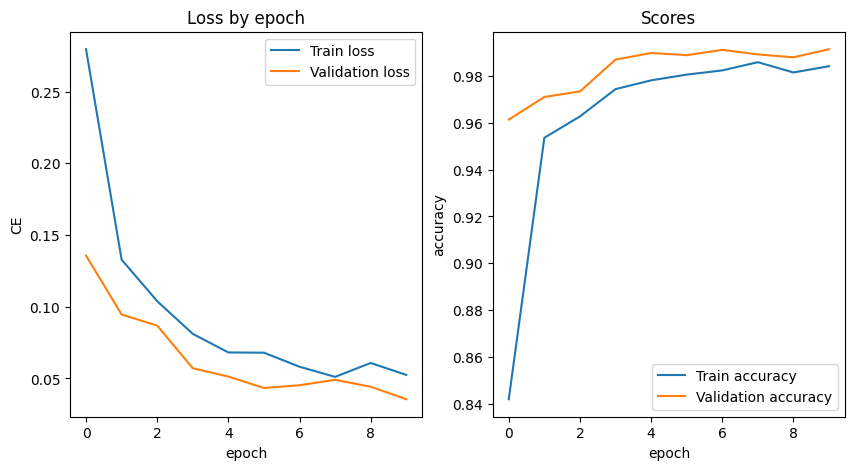

In [31]:
train.show_graph(results=result)

In [114]:
backbone = resnet.prunnedResnet18(
    pretrained=True,
    freeze_ratio=0.65,
    remove_classifier=True,
    reinit_weigths=False)
model = siamesenet.siameseNet(backbone,512)
checkpoint = torch.load('../checkpoints/siamese_resnet_18_nonaug.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640


<All keys matched successfully>

In [119]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/siamese')

In [120]:
img1,img2,labels = next(iter(dataloader['val']))
writer.add_graph(model, (img1.to(device),img2.to(device)))
writer.close()

Test Accuracy: 0.9752
Test Precision: 0.9423
Test Recall: 0.9423


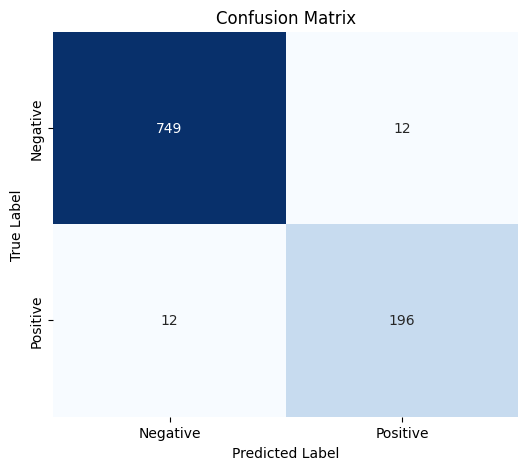

(0.9752321981424149,
 0.9423076923076923,
 0.9423076923076923,
 array([[749,  12],
        [ 12, 196]], dtype=int64))

In [116]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)

Test Accuracy: 0.9030
Test Precision: 0.8175
Test Recall: 0.9430


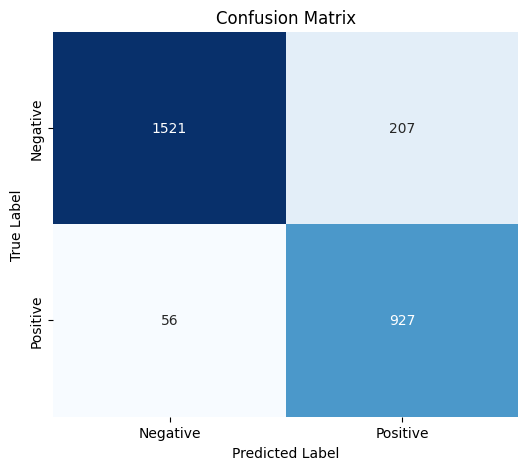

(0.9029878273699742,
 0.8174603174603174,
 0.943031536113937,
 array([[1521,  207],
        [  56,  927]], dtype=int64))

In [124]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_not_used_classes",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)

Test Accuracy: 0.4286
Test Precision: 1.0000
Test Recall: 0.0769


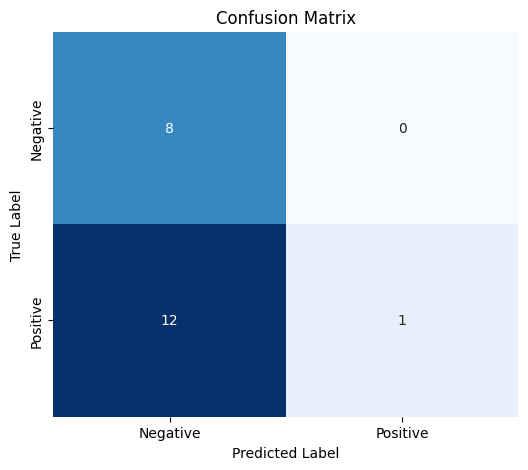

(0.42857142857142855,
 1.0,
 0.07692307692307693,
 array([[ 8,  0],
        [12,  1]], dtype=int64))

In [89]:
test_dir(model=model,
         device=device,
         img_ref_path ='..\\data\\rl_scenario_test\\positives\pill_2.png',
         dir ='..\\data\\rl_scenario_test\\',
         input_size=(248,248),
)

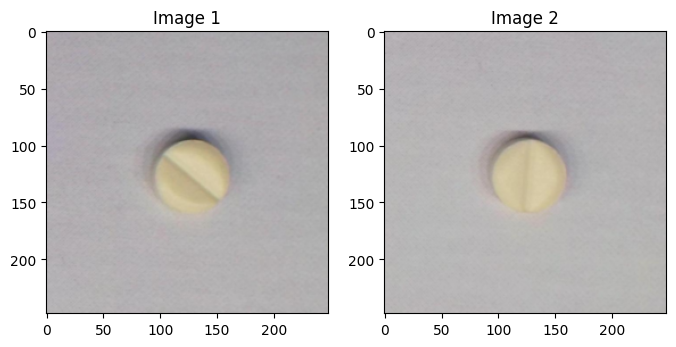

True Label: 1.0
Predicted Label: 1.0


In [129]:
train.test_random_sample(test_dataloader,model)

Predicted class is 0.0


{'Label': 0.0, 'Probability': 0.4196949899196625}

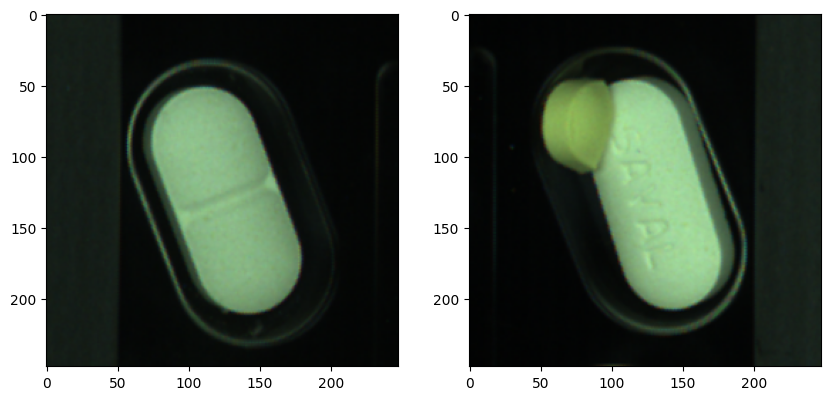

In [131]:
train.test_sample(model,'..\\data\\rl_scenario_test\\positives\\pill_3.png', '..\\data\\rl_scenario_test\\negatives\\pill_18.png', input_size=(248,248) )

## Non-augmented OneShot

In [98]:
batch_size = 256

transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=1.0),
    A.GridElasticDeform(num_grid_xy = (10,10), magnitude = 15, p=1.0),
    A.Resize(105,105),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=6,
    max_negative_combinations=6,
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

In [25]:
backbone = siamesenet.OneShot()
model = siamesenet.siameseNet(backbone)
result = train.train_siamese_network_V2(model=model,
                                        dataloader=dataloader,
                                        epochs=10,
                                        name="siamese_og_nonaug",
                                        checkpoint_path="..//checkpoints")

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

val_loss 0.26116 val_acc 0.91002: 100%|██████████| 36/36 [02:24<00:00,  4.02s/it]


Epoch 1/10 loss 0.40147 val_loss 0.26116 acc 0.79354 val_acc 0.91002
Best model saved with Validation Accuracy: 0.9100


val_loss 0.16212 val_acc 0.95238: 100%|██████████| 36/36 [02:34<00:00,  4.30s/it]


Epoch 2/10 loss 0.20298 val_loss 0.16212 acc 0.93556 val_acc 0.95238
Best model saved with Validation Accuracy: 0.9524


val_loss 0.17745 val_acc 0.93074: 100%|██████████| 36/36 [02:34<00:00,  4.28s/it]


Epoch 3/10 loss 0.15278 val_loss 0.17745 acc 0.94904 val_acc 0.93074


val_loss 0.11748 val_acc 0.96872: 100%|██████████| 36/36 [02:33<00:00,  4.26s/it]


Epoch 4/10 loss 0.12765 val_loss 0.11748 acc 0.96693 val_acc 0.96872
Best model saved with Validation Accuracy: 0.9687


val_loss 0.15027 val_acc 0.94537: 100%|██████████| 36/36 [02:35<00:00,  4.31s/it]


Epoch 5/10 loss 0.11383 val_loss 0.15027 acc 0.96853 val_acc 0.94537


val_loss 0.10798 val_acc 0.97308: 100%|██████████| 36/36 [02:34<00:00,  4.29s/it]


Epoch 6/10 loss 0.09043 val_loss 0.10798 acc 0.97827 val_acc 0.97308
Best model saved with Validation Accuracy: 0.9731


val_loss 0.07168 val_acc 0.98241: 100%|██████████| 36/36 [02:04<00:00,  3.47s/it]


Epoch 7/10 loss 0.08904 val_loss 0.07168 acc 0.97910 val_acc 0.98241
Best model saved with Validation Accuracy: 0.9824


val_loss 0.10939 val_acc 0.96908: 100%|██████████| 36/36 [02:03<00:00,  3.42s/it]


Epoch 8/10 loss 0.08521 val_loss 0.10939 acc 0.97761 val_acc 0.96908


val_loss 0.14446 val_acc 0.94598: 100%|██████████| 36/36 [01:59<00:00,  3.33s/it]


Epoch 9/10 loss 0.07153 val_loss 0.14446 acc 0.98066 val_acc 0.94598


val_loss 0.20148 val_acc 0.89954: 100%|██████████| 36/36 [02:01<00:00,  3.36s/it]

Epoch 10/10 loss 0.06590 val_loss 0.20148 acc 0.98424 val_acc 0.89954


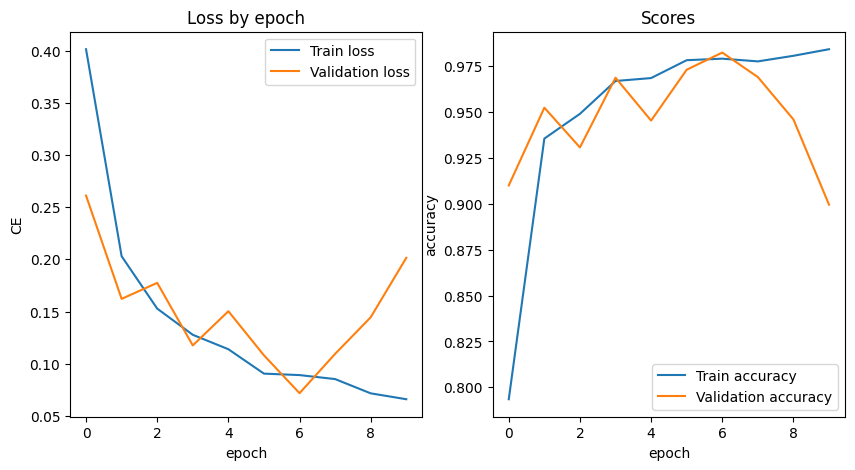

In [27]:
train.show_graph(results=result)

In [102]:
backbone = siamesenet.OneShot()
model = siamesenet.siameseNet(backbone)
checkpoint = torch.load('../checkpoints/siamese_og_nonaug.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

<All keys matched successfully>

In [104]:
img1,img2,labels = next(iter(dataloader['val']))
writer.add_graph(model, (img1.to(device),img2.to(device)))
writer.close()

Test Accuracy: 0.9721
Test Precision: 0.9209
Test Recall: 0.9519


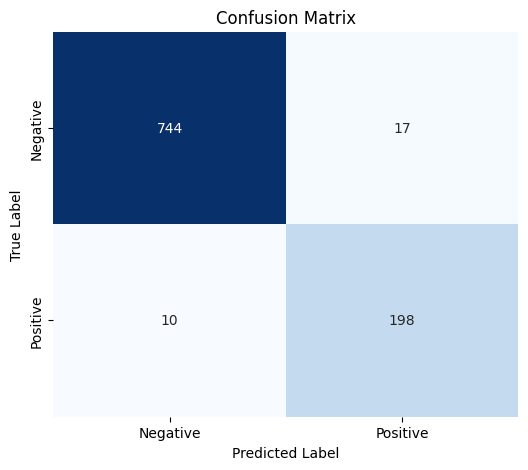

(0.9721362229102167,
 0.9209302325581395,
 0.9519230769230769,
 array([[744,  17],
        [ 10, 198]], dtype=int64))

In [103]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)

Test Accuracy: 0.8060
Test Precision: 0.6636
Test Recall: 0.9430


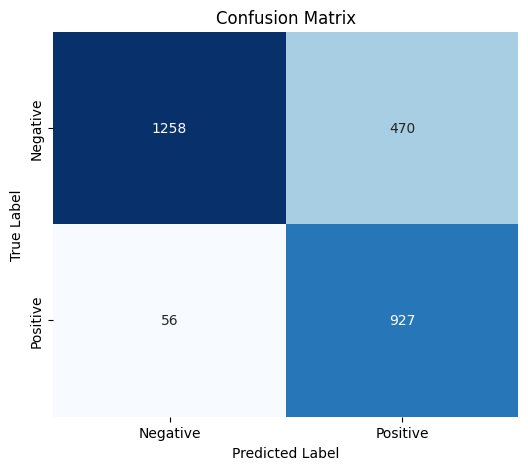

(0.8059756547399484,
 0.6635647816750179,
 0.943031536113937,
 array([[1258,  470],
        [  56,  927]], dtype=int64))

In [23]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_not_used_classes",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
train.evaluate_model(test_loader=test_dataloader,
                     model=model)